# Hyperparameter Optimization mit hyperas

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import h5py
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
import seaborn as sn
from wordcloud import WordCloud

from hyperopt import Trials, STATUS_OK, tpe

from keras.models import Sequential
from keras.layers import Dense, Dropout, LeakyReLU, Activation
from keras.regularizers import l2, l1
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
from keras.callbacks import EarlyStopping
from keras.models import load_model

from hyperas import optim
from hyperas.distributions import choice, uniform, normal, qlognormal, randint

Using TensorFlow backend.


# How are the Hyperparameter distributed

## Strukture

size of first and second hidden layer

In [ ]:
x = np.round(np.random.lognormal(7,0.5,10000)/10)*10
plt.hist(x,bins=100)
plt.xlim(0,5000)
plt.show()

size of third hidden layer

In [ ]:
x = np.round(np.random.lognormal(4,0.5,10000)/1)*1
plt.hist(x,bins=100)
plt.show()

## Regularization

In [ ]:
x =np.random.uniform(0,0.1,10000)
plt.hist(x,bins=100)
plt.show()

### Data preparation

In [ ]:
def data_Bert():
    news = pd.read_csv('../data/mixed_news/news_dataset.csv')
    news = news.dropna(subset=['title','content'])
    news = news[news.content != ' ']
    news = news[news.title != ' ']
    with h5py.File('encoded_data/title_encode.h5', 'r') as hf:
        title_encode = hf['title_encode'][:]
    title_NN = pd.DataFrame(data = title_encode)
    x_train, x_test, y_train, y_test = train_test_split(title_NN,news.label, test_size=0.33, stratify=news.label,
                                                        random_state=42)
    LE = LabelEncoder()
    LE.fit(["fake","real"])
    y_train = LE.transform(y_train)
    y_test = LE.transform(y_test)
    return x_train, y_train, x_test, y_test

In [2]:
def data_bow():
    x_test = np.genfromtxt("../build/preprocessed/bow_X_test.txt")
    x_train = np.genfromtxt("../build/preprocessed/bow_X_train.txt")
    y_test = np.genfromtxt("../build/preprocessed/bow_y_test.txt")
    y_train = np.genfromtxt("../build/preprocessed/bow_y_train.txt")
    return x_train, y_train, x_test, y_test

## Model creation

In [ ]:
def model_structure(x_train, y_train, x_test, y_test):
    dim = x_train.shape[1]
    model = Sequential()
    model.add(Dense({{qlognormal(7,0.5,10)}}, input_dim=dim))
    model.add(Activation('relu'))
    
    if {{choice(['three', 'four'])}} == 'four':
        model.add(Dense({{qlognormal(7,0.5,10)}}))
        model.add(Activation('relu'))
        
    model.add(Dense({{qlognormal(4,0.5,1)}}))
    model.add(Activation('relu'))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.compile(loss='binary_crossentropy', metrics=['accuracy'],
                  optimizer='adam')

    result = model.fit(x_train, y_train,
              batch_size=64,
              epochs=30,
              verbose=2,
              validation_split=0.3)
    validation_acc = np.amax(result.history['val_acc']) 
    print('Best validation acc of epoch:', validation_acc)
    return {'loss': -validation_acc, 'status': STATUS_OK, 'model': model}

In [ ]:
def model_training(x_train, y_train, x_test, y_test):
    dim = x_train.shape[1]
    model = Sequential()
    model.add(Dense(int(np.abs(1187.5872913047178)), input_dim=dim))
    model.add(Activation('relu'))
    model.add(Dense(int(np.abs(-1475.2916969518506))))
    model.add(Activation('relu'))    
    model.add(Dense(261))
    model.add(Activation('relu'))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.compile(loss={{choice(['hinge','binary_crossentropy','squared_hinge'])}}, metrics=['accuracy'],
                  optimizer={{choice(['adam','AdaDelta','Adagrad'])}})

    result = model.fit(x_train, y_train,
              batch_size=64,
              epochs=30,
              verbose=2,
              validation_split=0.3)
    validation_acc = np.amax(result.history['val_acc']) 
    print('Best validation acc of epoch:', validation_acc)
    return {'loss': -validation_acc, 'status': STATUS_OK, 'model': model}

In [ ]:
def model_regularization(x_train, y_train, x_test, y_test):
    dim = x_train.shape[1]
    model = Sequential()
    model.add(Dense(int(np.abs(1187.5872913047178)), kernel_regularizer=l1({{uniform(0,0.1)}}), input_dim=dim))
    model.add(Activation('relu'))
    model.add(Dense(int(np.abs(-1475.2916969518506)),kernel_regularizer=l2({{uniform(0,0.1)}})))
    model.add(Activation('relu'))    
    model.add(Dense(261,kernel_regularizer=l2({{uniform(0,0.1)}})))
    model.add(Activation('relu'))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.compile(loss='binary_crossentropy', metrics=['accuracy'],
                  optimizer='Adagrad')

    result = model.fit(x_train, y_train,
              batch_size=64,
              epochs=30,
              verbose=2,
              validation_split=0.3)
    validation_acc = np.amax(result.history['val_acc']) 
    print('Best validation acc of epoch:', validation_acc)
    return {'loss': -validation_acc, 'status': STATUS_OK, 'model': model}

## Optimization with hyperopt
Algorithm: Tree of Parzen Estimators

In [ ]:
trials = Trials()
best_run, best_model = optim.minimize(model=model_structure,
                                      data=data_bow,
                                      algo=tpe.suggest,
                                      max_evals=50,
                                      trials=trials,
                                     notebook_name='Hyperopt')
print("Best performing model chosen hyper-parameters:")
print(best_run)
best_model.save('../model/best_Hyperopt_NN_bow_struct.hdf5')

In [ ]:
trials = Trials()
best_run, best_model = optim.minimize(model=model_training,
                                      data=data_bow,
                                      algo=tpe.suggest,
                                      max_evals=15,
                                      trials=trials,
                                     notebook_name='Hyperopt')
print("Best performing model chosen hyper-parameters:")
print(best_run)
best_model.save('../model/best_Hyperopt_NN_bow_training.hdf5')

In [ ]:
trials = Trials()
best_run, best_model = optim.minimize(model=model_regularization,
                                      data=data_bow,
                                      algo=tpe.suggest,
                                      max_evals=80,
                                      trials=trials,
                                     notebook_name='Hyperopt')
print("Best performing model chosen hyper-parameters:")
print(best_run)
best_model.save('../model/best_Hyperopt_NN_bow_regularization.hdf5')

## Evaluation of best model

In [3]:
X_train, Y_train, X_test, Y_test = data_bow()
best_model = load_model('../model/best_Hyperopt_NN_bow_regularization.hdf5')
y_pred = best_model.predict(X_test, batch_size=64, verbose=1)
y_pred_train = best_model.predict(X_train, batch_size=64, verbose=1)
y_pred_bool = np.round(y_pred)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
19513/19513 [==============================] - 4s 206us/step


In [19]:
print(classification_report(Y_test, y_pred_bool))
print(confusion_matrix(Y_test, y_pred_bool,labels=[0,1]))

#Confusion Matrix
cnfn_matrix = pd.crosstab(Y_test, y_pred_bool[:,0], rownames=['Actual'], colnames=['Predicted'])
print(cnfn_matrix)
cnfn_matrix.columns = ['fake','real']
cnfn_matrix = cnfn_matrix.rename_axis("Predicted", axis="columns")
cnfn_matrix.rename(index = {0.0: "fake", 1.0:'real'}, inplace = True) 
cnfn_matrix = cnfn_matrix/Y_test.shape[0]
sn.heatmap(cnfn_matrix, annot=True , cmap='viridis')
#plt.show()
plt.savefig("../build/plots/bow/cnfsn_mtx_bow_best_nn.pdf")
plt.close()

#Overtraining test
plt.hist(y_pred[Y_test == 0],label="fake test", alpha = 0.4, color = "r",density=True)
plt.hist(y_pred_train[Y_train == 0],label='fake train', alpha = 0.4, color = 'r', histtype='step',density=True)
plt.hist(y_pred[Y_test == 1],label = "real test",alpha = 0.4, color = "b",density=True)
plt.hist(y_pred_train[Y_train == 1],label='real train', alpha = 0.4, color = 'b', histtype='step',density=True)

plt.xlabel("Prediction Probability")
plt.ylabel("density")
plt.legend(loc='upper center')
#plt.show()
plt.savefig("../build/plots/Bert/prob_bert_title_nn.pdf")
plt.close()

fpr = dict()
tpr = dict()
roc_auc = dict()
fpr, tpr, _ = roc_curve(Y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
#plt.show()
plt.savefig("../build/plots/bow/roc_Hyperopt_bow_best_nn.pdf")
plt.close()

              precision    recall  f1-score   support

         0.0       0.90      0.90      0.90      3650
         1.0       0.92      0.92      0.92      4714

   micro avg       0.91      0.91      0.91      8364
   macro avg       0.91      0.91      0.91      8364
weighted avg       0.91      0.91      0.91      8364

[[3291  359]
 [ 368 4346]]
Predicted   0.0   1.0
Actual               
0.0        3291   359
1.0         368  4346


## Interpretation

### Wordclkoud confusion matrix

In [59]:
results = pd.DataFrame({'prediction':y_pred[:,0],'prediction_bool':y_pred_bool[:,0],'truth':Y_test})
results['dist'] = np.abs(results.truth - results.prediction)
results = results.sort_values('dist',axis=0,ascending=False)
FP = results[(results.prediction_bool== 1) & (results.truth == 0)]
FN = results[(results.prediction_bool== 0) & (results.truth == 1)]
TP = results[(results.prediction_bool== 1) & (results.truth == 1)]
TN = results[(results.prediction_bool== 0) & (results.truth == 0)]
X_test = pd.DataFrame(X_test)
X_FP = X_test.loc[FP.index]
X_FN = X_test.loc[FN.index]
X_TP = X_test.loc[TP.index]
X_TN = X_test.loc[TN.index]
f = open("../build/preprocessed/bow_feature_names.txt", "r")
words = [x[:-1] for x in f]
X_FP.columns = words
X_FN.columns = words
X_TP.columns = words
X_TN.columns = words

In [122]:
from wordcloud import WordCloud
from PIL import Image
from PIL import ImageFilter
def plotWordcloud_cnfn(TN,FN,FP,TP):    
    TN = TN.sum().to_dict()
    FN = FN.sum().to_dict()
    FP = FP.sum().to_dict()
    TP = TP.sum().to_dict()
    
    fig = plt.figure()

    plt.subplot(2, 2, 1)
    wordcloud = WordCloud(background_color='black',
                          width=1920,
                          height=1080,
                          mask=np.array(Image.open('../data/pictures/trump_silhouette.png'))
                          ).generate_from_frequencies(TN)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.margins(x=0, y=0)

    plt.subplot(2, 2, 2)
    wordcloud = WordCloud(background_color='black',
                          width=1920,
                          height=1080,
                          mask= np.array(Image.open('../data/pictures/trump_silhouette.png'))
                          ).generate_from_frequencies(FP)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.margins(x=0, y=0)

    plt.subplot(2, 2, 3)
    wordcloud = WordCloud(background_color='black',
                          width=1920,
                          height=1080,
                          mask=np.array(Image.open('../data/pictures/USA.jpg'))
                          ).generate_from_frequencies(FN)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.margins(x=0, y=0)

    plt.subplot(2, 2, 4)
    wordcloud = WordCloud(background_color='black',
                          width=1920,
                          height=1080,
                          mask=np.array(Image.open('../data/pictures/USA.jpg'))
                          ).generate_from_frequencies(TP)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.margins(x=0, y=0)

    #plt.show()
    plt.savefig("../build/plots/bow/cnfn_wordcloud.pdf")
    plt.close()

In [123]:
plotWordcloud_cnfn(X_TN,X_FN,X_FP,X_TP)

### Wordcloud fake real news

In [124]:
def plotWordcloud(content,t):
    if(t!=""):
       mask = np.array(Image.open('../data/pictures/'+t))
    else:
        mask=None
        

    content = content.sum().to_dict()
    wordcloud = WordCloud(background_color='black',
                      width=1920,
                      height=1080,
                      mask=mask
                      ).generate_from_frequencies(content)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.margins(x=0, y=0)

In [125]:
X = np.append(X_test,X_train,axis=0)
y = np.append(Y_test,Y_train,axis=0)
X = pd.DataFrame(X)
X.columns = words
plotWordcloud(X[y==0],"trump_silhouette.png")
plt.savefig("../build/plots/fake_wordcloud.pdf")
plt.close()
plotWordcloud(X[y==1],"USA.jpg")
plt.savefig("../build/plots/real_wordcloud.pdf")
plt.close()

## Untersuchung der first layer

In [161]:
first_weights = best_model.layers[0].get_weights()[0]
first_weights = pd.DataFrame(first_weights.transpose())
first_weights.columns = words
first_weightabs = np.abs(first_weights)
first_weightsum = first_weightabs.sum(axis=0)
content = np.abs(first_weightsum).to_dict()
wordcloud = WordCloud(background_color='black',
                      width=1920,
                      height=1080
                      ).generate_from_frequencies(content)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.margins(x=0, y=0)
#plt.show()
plt.savefig("../build/plots/bow/weights_wordcloud.pdf")
plt.close()

Der offset wird nicht mitbetrachtet und macht wahrscheinlich eh keinen Sinn, zu betrachten ob es positiv oder negativ wirkt

via        -6.075896
the        -5.617600
november   -4.981290
anti       -4.665751
email      -4.240753
perhaps     4.227066
monday      4.357511
saturday    4.545452
thursday    5.289875
friday      7.415503
dtype: float32

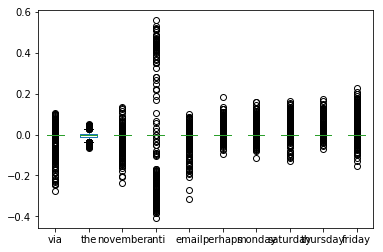

In [154]:
sorted_weightsum = first_weightsum.sort_values()
neg_weights = first_weights[sorted_weightsum[:5].index]
pos_weights = first_weights[sorted_weightsum[-5:].index]
plot_weights = pd.concat([neg_weights,pos_weights],axis=1)
plot_weights.plot(kind='box')
plt.show()

In [101]:
news = pd.read_csv('../data/mixed_news/news_dataset.csv')

In [160]:
news[news.label=='fake'].iloc[0].content

'Print They should pay all the back all the money plus interest. The entire family and everyone who came in with them need to be deported asap. Why did it take two years to bust them? \nHere we go again …another group stealing from the government and taxpayers! A group of Somalis stole over four million in government benefits over just 10 months! \nWe’ve reported on numerous cases like this one where the Muslim refugees/immigrants commit fraud by scamming our system…It’s way out of control! More Related'